In [12]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [13]:
#for trial 3
from scipy.optimize import minimize
from scipy.io import loadmat

In [14]:
#for trial 2
def plot_spikes_with_prediction(
    input_stream, predicted_input_stream, dt, nt=50, t0=120, **kws):
  """Plot actual and predicted spike counts.

  Args:
    spikes (1D array): Vector of actual spike counts
    predicted_spikes (1D array): Vector of predicted spike counts
    dt (number): Duration of each time bin.
    nt (number): Number of time bins to plot
    t0 (number): Index of first time bin to plot.
    kws: Pass additional keyword arguments to plot()

  """
  t = np.arange(t0, t0 + nt) * dt

  f, ax = plt.subplots()
  lines = ax.stem(t, input_stream[:nt], use_line_collection=True)
  plt.setp(lines, color=".5")
  lines[-1].set_zorder(1)
  kws.setdefault("linewidth", 3)
  yhat, = ax.plot(t, predicted_input_stream[:nt], **kws)
  ax.set(
      xlabel="Time (s)",
      ylabel="Input",
  )
  ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
  ax.legend([lines[0], yhat], ["input_stream", "Predicted"])

  plt.show()

In [15]:
# Set some properties of the model. We'll store these in a dict so they're
# easier to pass around or save.
model = {}

# properties of the recurrent pool:
model['N']      = 1000                 # number of neurons
model['g']      = 0.95                 # gain of synaptic weights in pool
model['sp']     = 0.25                 # fraction of weights that are nonzero
model['tau']    = 20                   # neural membrane time constant in ms
model['dt']     = 0.1                  # simulation timestep in ms
model['nonlin'] = lambda x: np.tanh(x) # firing rate nonlinearity for pool units

# properties of the input layer:
# a note: we're going to encode the "value" of the input by the identity of the
# active input layer units. We'll use one-hot encoding: for each input step
# during simulation, one unit will be activated with "firing rate" 1, and the
# rest will be set to firing rate 0 (adjust gIn to change the scaling of input
# to the recurrent pool.)
# Note 1: This is just one way of setting up input- are there other approaches
# that would improve memory capacity?
# Note 2: Burn-in time is especially important if your model has g>1, in which
# case neurons will be spontaneously active.
model['nIn']    = 20                   # size of the input layer
model['gIn']    = 10.0                 # gain of the input weights
model['spIn']   = 0.05                 # sparsity of input->pool connectivity
model['burnIn'] = 10                   # time before input starts
model['durIn']  = 1                    # time for which an input is active in ms
model['ISI']    = 0                    # time between inputs in ms
model['nonlinIn'] = lambda x: x        # best to keep the input linear

In [16]:
# Create the synaptic weight matrix.
# Normalizing weights by sqrt(N*sparsity) keeps the eigenvalue spectrum
# invariant to the size of the population N.
randMat      = np.random.normal(0, 1, size=(model['N'], model['N']))
spMat        = np.random.uniform(0, 1, size=(model['N'], model['N'])) \
                <= model['sp']
model['J']   = np.multiply(randMat, spMat) \
                * model['g'] / math.sqrt(model['N'] * model['sp'])

# Create the input weight matrix.
randMatIn    = np.random.normal(0, 1, size=(model['N'], model['nIn']))
spMatIn      = np.random.uniform(0, 1, size=(model['N'], model['nIn'])) \
                <= model['spIn']
model['Jin'] = np.multiply(randMatIn, spMatIn) \
                * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])

In [17]:
# Define a couple helper functions for simulation.

def step(firing_rates, input_layer, model):
  # The simulation function. We use Euler's method to simulate the evolution of
  # model neuron firing rates given the input_layer firing rates.
  
  timestep = math.exp(-model['dt']/model['tau'])
  vIn = np.matmul(model['J'], firing_rates) \
        + np.matmul(model['Jin'], model['nonlinIn'](input_layer))
  updated_rates = model['nonlin'](vIn + (firing_rates - vIn) * timestep)

  return updated_rates


def make_input(sequence_length, model):
  # Generates a sequence of inputs according to the parameters in model. Returns
  # the sequence both as a one-hot encoding and as a sequence of integer values.

  input_stream = [0] * int(model['burnIn']/model['dt'])

  for i in range(sequence_length):
    val = np.random.randint(0, model['nIn']) + 1
    for t in range(int(model['ISI']/model['dt'])):
      input_stream.append(0.0)
    for t in range(int(model['durIn']/model['dt'])):
      input_stream.append(val)
    
  input_stream = np.array(input_stream)

  onehot = np.zeros((model['nIn']+1, input_stream.size))
  onehot[input_stream, np.arange(input_stream.size)] = 1.0
  onehot = onehot[1:,:]

  return onehot, input_stream

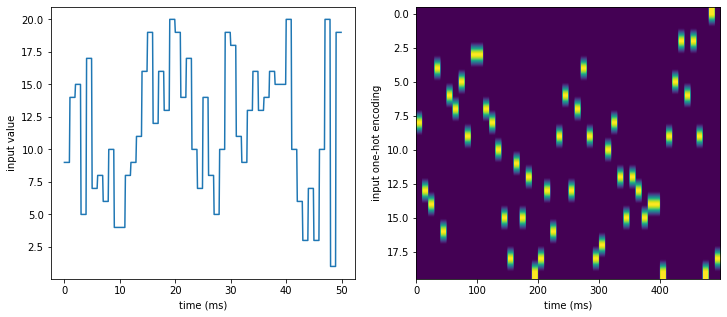

In [18]:
# Look at an example input stream.

onehot, stream = make_input(50, model)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
omit = int(model['burnIn']/model['dt']) # don't plot the burn-in period
ax[0].plot(np.arange(len(stream) - omit) * model['dt'], stream[omit:]);
ax[0].set_xlabel('time (ms)');
ax[0].set_ylabel('input value');

ax[1].imshow(onehot[:, omit:], aspect='auto');
ax[1].set_xlabel('time (ms)');
ax[1].set_ylabel('input one-hot encoding');

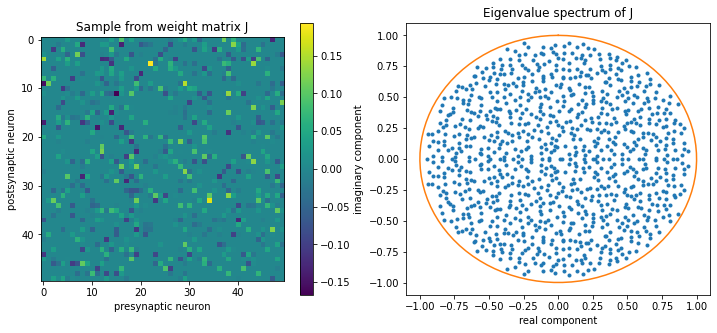

In [19]:
# Take a look at the eigenvalue spectrum of J.
w, v = np.linalg.eig(model['J'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
showCount = 50  # portion of J to actually show (for readability)
h=ax[0].imshow(model['J'][:showCount,:showCount]);
ax[0].set_title('Sample from weight matrix J');
ax[0].set_xlabel('presynaptic neuron');
ax[0].set_ylabel('postsynaptic neuron');
plt.colorbar(h, ax=ax[0]);

ax[1].plot(np.real(w),np.imag(w),'.');
ax[1].plot(np.sin(np.linspace(0,2*math.pi,100)),
           np.cos(np.linspace(0,2*math.pi,100))); # circle with radius 1
ax[1].set_title('Eigenvalue spectrum of J')
ax[1].set_xlabel('real component');
ax[1].set_ylabel('imaginary component');

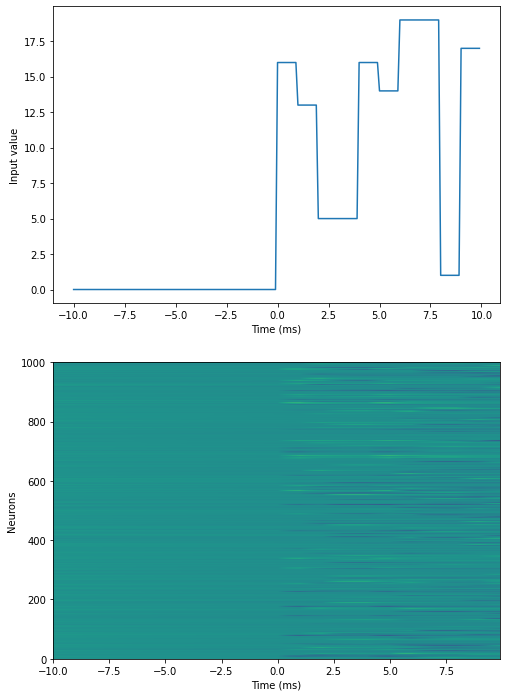

In [20]:
# Simulate the model activity.

# generate the input to the model
onehot, input_stream = make_input(10, model)

# initialize the firing rates randomly
firing_rates = np.zeros((model['N'], len(input_stream)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(input_stream)-1):
  firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)


fig, ax = plt.subplots(2, 1, figsize=(8, 12))
simulation_time = np.arange(len(input_stream))*model['dt'] - model['burnIn']
ax[0].plot(simulation_time, input_stream);
ax[0].set_xlabel('Time (ms)');
ax[0].set_ylabel('Input value');

extents = [simulation_time[0],simulation_time[-1], 0, model['N']]
ax[1].imshow(firing_rates, aspect='auto', extent=extents);
ax[1].set_xlabel('Time (ms)');
ax[1].set_ylabel('Neurons');

Now: can you decode the model's input history from its firing rates?

In [22]:
def make_design_matrix(resp, d=20):
  """Create time-lag design matrix from stimulus intensity vector.
  Args:
    stim (1D array): Stimulus intensity at each time point. #response: 2D matrix
    d (number): Number of time lags to use.
  Returns
    X (2D array): GLM design matrix with shape T, d
  """
  # Create version of stimulus vector with zeros before onset
  padded_resp = np.hstack([resp, np.zeros((1000, d - 1))])

  # Construct a matrix where each row has the d frames of
  # the stimulus proceeding and including timepoint t
  T = len(input_stream)  # Total number of timepoints (hint: number of stimulus frames)
  X = np.zeros((T, d * model['N']))
  for t in range(T):
      X[t,:] = padded_resp[:, t:t + d].flatten()

  return X


def neg_log_lik_lnp(theta, X, y):
  """Return -loglike for the Poisson GLM model.
  Args:
    theta (1D array): Parameter vector.
    X (2D array): Full design matrix.
    y (1D array): Data values.
  Returns:
    number: Negative log likelihood.
  """
  # Compute the Poisson log likeliood
  rate = np.exp(X @ theta)
  log_lik = y @ np.log(rate) - rate.sum()
  return -log_lik


def fit_lnp(firing_rates, input_stream, d=25):
  """Obtain MLE parameters for the Poisson GLM.
  Args:
    stim (1D array): Stimulus values at each timepoint
    spikes (1D array): Spike counts measured at each timepoint
    d (number): Number of time lags to use.
  Returns:
    1D array: MLE parameters
  """

  # Build the design matrix
  y = input_stream
  constant = np.ones_like(y)
  X = np.column_stack([constant, make_design_matrix(firing_rates)])

  # Use a random vector of weights to start (mean 0, sd .2)
  x0 = np.random.normal(0, .2, d + 1)

  # Find parameters that minmize the negative log likelihood function
  res = minimize(neg_log_lik_lnp, x0, args=(X, y))

  return res["x"]


# Fit LNP model
theta_lnp = fit_lnp(firing_rates, input_stream)

# Visualize
with plt.xkcd():
  plot_spike_filter(theta_lg[1:], dt_stim, color=".5", label="LG")
  plot_spike_filter(theta_lnp[1:], dt_stim, label="LNP")
  plt.legend(loc="upper left");

ValueError: ignored

In [ ]:
def predict_input_stream_lnp(firing_rates, input_stream, theta=None, d=25):
  """Compute a vector of predicted spike counts given the stimulus.
  Args:
    stim (1D array): Stimulus values at each timepoint
    spikes (1D array): Spike counts measured at each timepoint
    theta (1D array): Filter weights; estimated if not provided.
    d (number): Number of time lags to use.
  Returns:
    yhat (1D array): Predicted spikes at each timepoint.
  """
  y = input_stream
  constant = np.ones_like(spikes)
  X = np.column_stack([constant, make_design_matrix(firing_rates)])
  if theta is None:  # Allow pre-cached weights, as fitting is slow
    theta = fit_lnp(X, y, d)

  yhat = np.exp(X @ theta)
  return yhat


# Predict spike counts
yhat = predict_input_stream_lnp(firing_rates, input_stream, theta_lnp)

#Visualize
fig, ax = plt.subplots(2, 1, figsize=(8, 12))
simulation_time = np.arange(len(input_stream))*model['dt'] - model['burnIn']
ax[0].plot(simulation_time, input_stream);
ax[0].set_xlabel('Time (ms)');
ax[0].set_ylabel('Input value');

ax[1].plot(simulation_time, yhat);
ax[1].set_xlabel('Time (ms)');
ax[1].set_ylabel('Predicted input value');

In [ ]:
mse = np.mean((input_stream - predicted_input_stream)**2)
print(mse)